<a href="https://colab.research.google.com/github/Ilona-11/cat-dog-Model-DenseNet/blob/main/UASDeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Maria Ilona Junide Bria (202211420006)**

# **Classification Gambar dan Bahasa**

### **Klasifikasi Hewan Kucing Dan Anjing Menggunakan Convolutional Neural Network (CNN) DenseNet**

DenseNet (Densely Connected Convolutional Network) adalah arsitektur convolusional yang unik karena setiap layer tidak hanya menerima input dari layer sebelumnya secara langsung, tapi menerima dan mengkonsolidasikan output (feature maps) dari semua layer sebelumnya. Dengan kata lain, untuk setiap layer l, inputnya adalah hasil concatenation dari output semua layer sebelumnya [x0,x1,...,xl−1].


# **Import dan Download Dataset**

Menggunakan library kagglehub untuk mengunduh dataset Cats and Dogs dari Kaggle. Dataset ini berisi folder untuk training dan testing dengan gambar kucing dan anjing. File dan folder dicek dan disiapkan untuk proses selanjutnya.

In [ ]:
import kagglehub

# Download dataset dari Kaggle
path = kagglehub.dataset_download("tongpython/cat-and-dog")

print("Path to dataset files:", path)

!ls /kaggle/input

import numpy as np
import pandas as pd
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
print("done")


Using Colab cache for faster access to the 'cat-and-dog' dataset.
Path to dataset files: /kaggle/input/cat-and-dog
cat-and-dog
done


# **Import Library CNN (DenseNet)**

Import library TensorFlow dan Keras serta modul DenseNet201 pretrained dari ImageNet, yang akan digunakan sebagai backbone model.

*   Tensorflow sebagai Kerangka utama deep learning.
*   ImageDataGenerator dari Keras untuk augmentasi dan preprocessing gambar.
*   DenseNet201 sebagai arsitektur backbone pretrained dari ImageNet yang akan diterapkan untuk transfer learning.
*   Module seperti Model, Dense, Dropout, GlobalAveragePooling2D, dan Adam adalah komponen penting untuk membangun, memodifikasi, dan mengoptimalkan arsitektur jaringan yang akan digunakan pada tugas klasifikasi dua kelas (biner)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


# **Siapkan Generator Gambar**

Menggunakan ImageDataGenerator untuk augmentasi data training seperti rotasi, translasi, zoom, flip horizontal, dan sekaligus membagi data menjadi training dan validation dengan validation_split=0.2. Ukuran input yang dipakai adalah 224x224 piksel sesuai DenseNet.

In [ ]:
IMG_SIZE = (224, 224)  # ukuran sesuai dengan DenseNet
BATCH_SIZE = 10

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/cat-and-dog/training_set/training_set',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/kaggle/input/cat-and-dog/training_set/training_set',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    "/kaggle/input/cat-and-dog/test_set/test_set",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 6404 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


# **Bangun Model DenseNet**

Model DenseNet201 digunakan tanpa top layer (fully connected) bawaan. Layer awal dibekukan kecuali 20 layer terakhir yang di-unfreeze untuk fine tuning. Kemudian ditambahkan global average pooling, dense layer 512 neuron, dropout 0.5 untuk regularisasi, dan output layer sigmoid untuk klasifikasi binary.


In [ ]:
# Menggunakan DenseNet201 (pretrained dari ImageNet)
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tuning sebagian layer
num_unfreeze_layers = 20
for layer in base_model.layers[:-num_unfreeze_layers]:
    layer.trainable = False
for layer in base_model.layers[-num_unfreeze_layers:]:
    layer.trainable = True

# Tambahkan lapisan klasifikasi
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 19,306,049 (73.65 MB)

 Trainable params: 1,585,985 (6.05 MB)

 Non-trainable params: 17,720,064 (67.60 MB)

# **Training Model**

Melatih model dengan 10 epoch menggunakan generator data yang sudah disiapkan.


In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 2243s 3s/step - accuracy: 0.9131 - loss: 0.2240 - val_accuracy: 0.9875 - val_loss: 0.0387
Epoch 2/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 2147s 3s/step - accuracy: 0.9721 - loss: 0.0853 - val_accuracy: 0.9844 - val_loss: 0.0393
Epoch 3/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 2110s 3s/step - accuracy: 0.9719 - loss: 0.0767 - val_accuracy: 0.9831 - val_loss: 0.0476
Epoch 4/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 2109s 3s/step - accuracy: 0.9842 - loss: 0.0440 - val_accuracy: 0.9850 - val_loss: 0.0424
Epoch 5/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 2133s 3s/step - accuracy: 0.9816 - loss: 0.0492 - val_accuracy: 0.9875 - val_loss: 0.0358
Epoch 6/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 2119s 3s/step - accuracy: 0.9877 - loss: 0.0324 - val_accuracy: 0.9825 - val_loss: 0.0462
Epoch 7/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 2131s 3s/step - accuracy: 0.9868 - loss: 0.0402 - val_accuracy: 0.9863 - val_loss: 0.0426
Epoch 8/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 2153s 3s/step - accuracy: 0.9883 - loss: 0.0287 - 

# **Plot Grafik Akurasi & Loss**

Menampilkan grafik akurasi dan loss untuk data training dan validation agar dapat melihat performa model selama training.


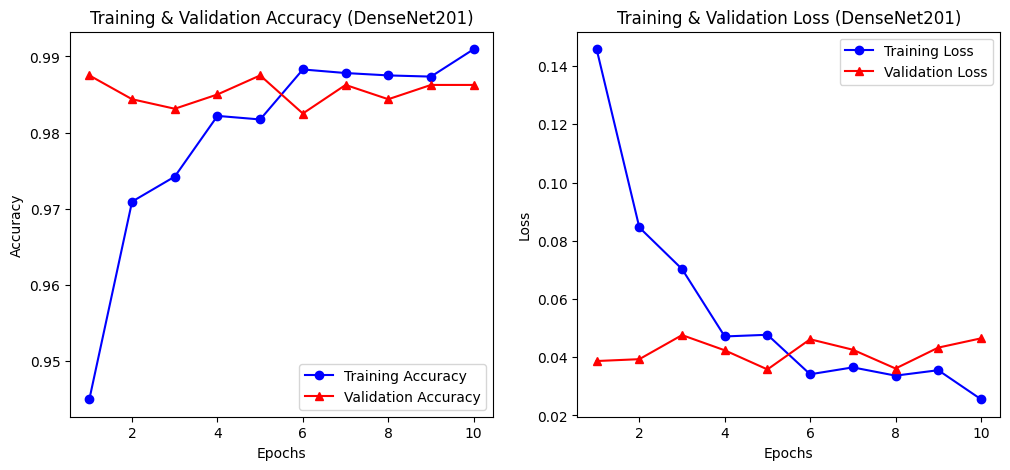

In [ ]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r^-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy (DenseNet201)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')
plt.title('Training & Validation Loss (DenseNet201)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# **Evaluasi Model pada Test Set**

Mengevaluasi model pada data test untuk mengukur akurasi dan loss final.


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


203/203 ━━━━━━━━━━━━━━━━━━━━ 524s 3s/step - accuracy: 0.9812 - loss: 0.0965

Test Accuracy: 0.9857
Test Loss: 0.0537


8. Simpan & Muat Model

In [ ]:
model_name = 'cat_dog_classifier_densenet.h5'
model.save(model_name)

# Load kembali model
loaded_model = tf.keras.models.load_model(model_name)


# **Prediksi dan Tampilkan Hasil**

Melakukan prediksi probabilitas dan kelas pada test set serta membandingkan dengan label asli.

In [ ]:
predictions = loaded_model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int)

print('Prediksi probabilitas:\n', predictions[:10])
print('Prediksi kelas (0=Kucing, 1=Anjing):\n', predicted_classes[:10].flatten())
print('Label sebenarnya:\n', test_generator.classes[:10])


203/203 ━━━━━━━━━━━━━━━━━━━━ 535s 3s/step
Prediksi probabilitas:
 [[4.8281517e-04]
 [2.0819657e-06]
 [2.1246735e-06]
 [8.9061693e-08]
 [2.0019625e-06]
 [2.1989706e-06]
 [8.8739029e-08]
 [8.2680219e-01]
 [6.0081284e-06]
 [7.3761516e-04]]
Prediksi kelas (0=Kucing, 1=Anjing):
 [0 0 0 0 0 0 0 1 0 0]
Label sebenarnya:
 [0 0 0 0 0 0 0 0 0 0]


# **Tampilkan Contoh Gambar**

Menampilkan satu gambar dari test set dengan label sebenarnya.

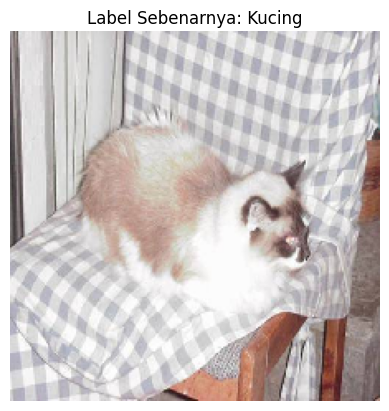

In [ ]:
test_images, test_labels = next(test_generator)

plt.imshow(test_images[0])
plt.title(f"Label Sebenarnya: {'Anjing' if test_labels[0] == 1 else 'Kucing'}")
plt.axis('off')
plt.show()


# **Visualisasi 25 Prediksi Pertama**

Menampilkan 25 contoh prediksi pertama lengkap warna hijau untuk benar dan merah jika salah.

64/64 ━━━━━━━━━━━━━━━━━━━━ 540s 8s/step


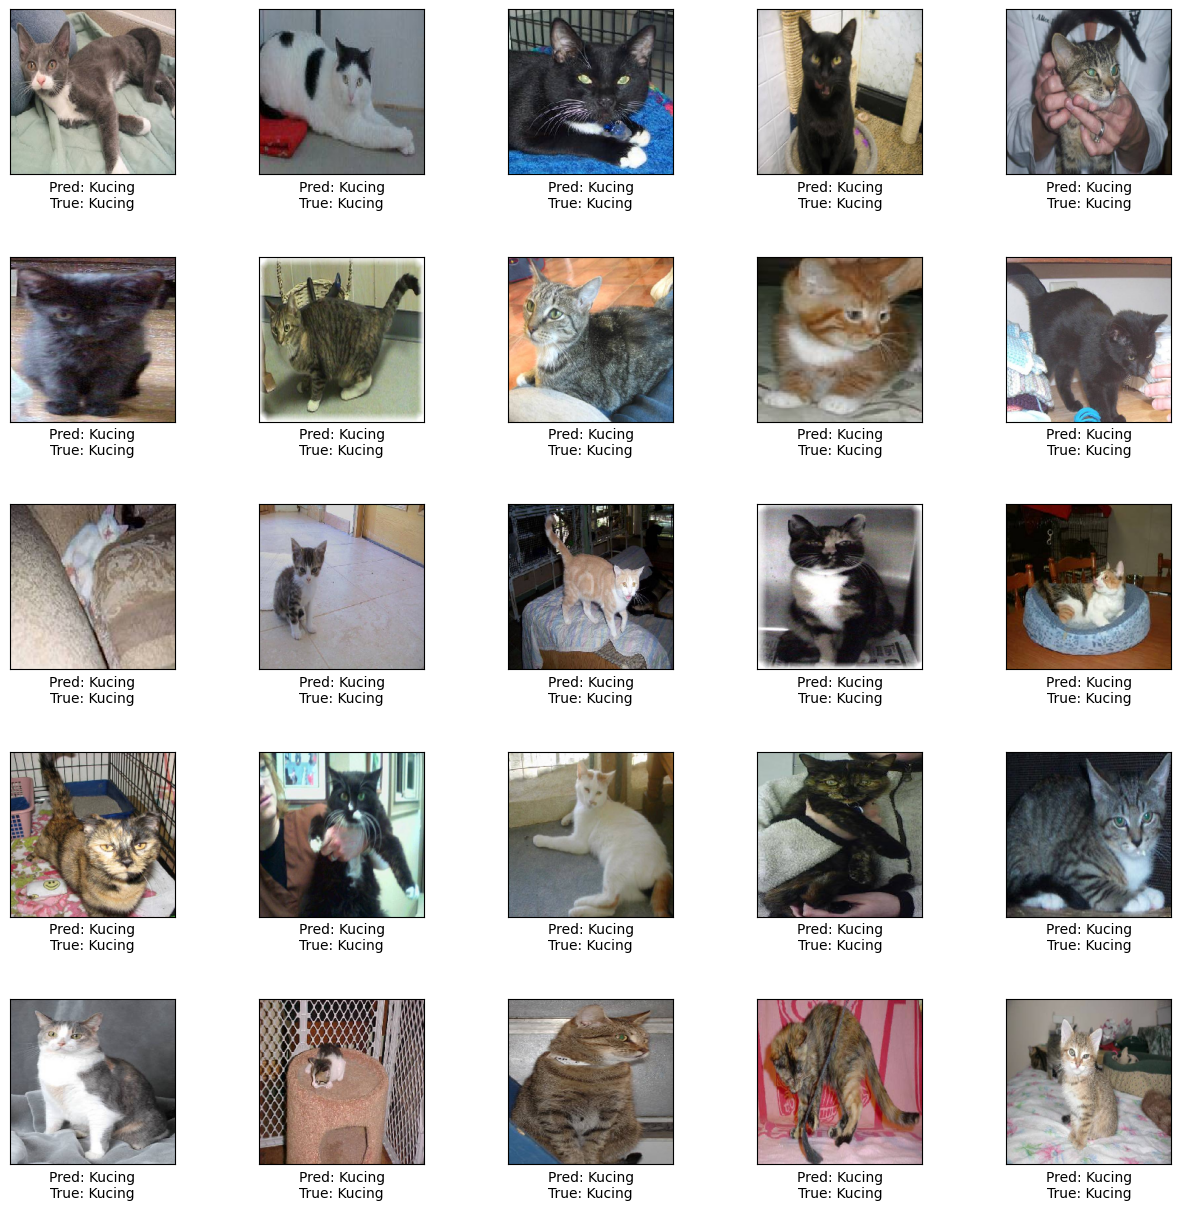

In [ ]:
import math

test_images_all, test_labels_all = [], []
for _ in range(len(test_generator)):
    images, labels = next(test_generator)
    test_images_all.extend(images)
    test_labels_all.extend(labels)

test_images_all = np.array(test_images_all)
test_labels_all = np.array(test_labels_all)

predictions_all = loaded_model.predict(test_images_all)
predicted_classes_all = (predictions_all > 0.5).astype(int).flatten()

numbers_to_display = 25
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(15, 15))

for i in range(numbers_to_display):
    plt.subplot(num_cells, num_cells, i + 1)
    plt.xticks([]); plt.yticks([]); plt.grid(False)
    predicted_name = 'Anjing' if predicted_classes_all[i] == 1 else 'Kucing'
    true_name = 'Anjing' if test_labels_all[i] == 1 else 'Kucing'
    color_map = 'Greens' if predicted_classes_all[i] == test_labels_all[i] else 'Reds'
    plt.imshow(test_images_all[i], cmap=color_map)
    plt.xlabel(f"Pred: {predicted_name}\nTrue: {true_name}", color='black')

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()


# **Confusion Matrix**

Menampilkan confusion matrix untuk evaluasi performa model klasifikasi secara detail.

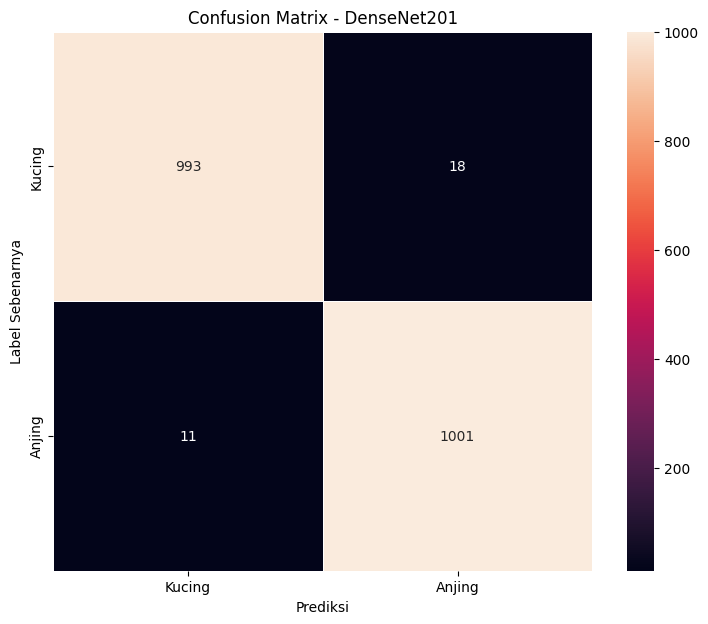

In [ ]:
import seaborn as sn

confusion_matrix = tf.math.confusion_matrix(test_labels_all, predicted_classes_all)

plt.figure(figsize=(9, 7))
sn.heatmap(confusion_matrix, annot=True, fmt='d', linewidths=.5, square=True,
           xticklabels=['Kucing', 'Anjing'],
           yticklabels=['Kucing', 'Anjing'])
plt.xlabel('Prediksi')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix - DenseNet201')
plt.show()
